# Bootstrapping method

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, r2_score # root_mean_squared_error
from sklearn.utils import resample

/opt/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
data = pd.read_csv('./seattle_data/seattle_sample_3k.csv')

In [3]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
data = data.to_crs(4326)

In [5]:
data

,Unnamed: 0,bathrooms,sqft_living,sqft_lot,grade,condition,waterfront,view,age,UTM_X,UTM_Y,log_price,geometry
0,0,3.00,2660,4600,8,3,0,0,109,552217.557035,5.274945e+06,6.091315,POINT (-122.30500 47.62580)
1,1,2.25,2530,8736,7,4,0,0,57,565692.484331,5.272758e+06,5.790988,POINT (-122.12600 47.60490)
2,2,2.00,1390,13464,7,4,0,0,28,562451.661509,5.245291e+06,5.315130,POINT (-122.17300 47.35810)
3,3,1.00,940,4264,7,5,0,0,66,546816.935618,5.264407e+06,5.619093,POINT (-122.37800 47.53140)
4,4,2.25,2070,7225,8,3,0,0,36,564343.195352,5.244978e+06,5.477121,POINT (-122.14800 47.35510)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,1.50,1290,8366,7,3,0,0,58,551377.991268,5.259321e+06,5.380211,POINT (-122.31800 47.48530)
2996,2996,1.50,1490,12186,7,4,0,0,65,550796.231636,5.291393e+06,5.566895,POINT (-122.32200 47.77390)
2997,2997,1.50,1510,16800,8,5,0,0,59,549619.278143,5.288838e+06,5.618048,POINT (-122.33800 47.75100)
2998,2998,2.00,1640,3021,7,3,0,2,56,548198.517745,5.279378e+06,5.732394,POINT (-122.35800 47.66600)


In [6]:
data['lat'] = data['geometry'].x

In [7]:
data['lon'] = data['geometry'].y

In [8]:
data['price'] = np.power(10, data['log_price']) / 10000

In [9]:
y = data.price
X_aspatial = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age']]
X_spatial = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]
loc = data[['lat','lon']]

In [10]:
X_aspatial_train_, X_apsatial_test_, X_spatial_train_, X_spatial_test_, y_train_, y_test_ = train_test_split(X_aspatial, X_spatial, y, train_size=0.8, random_state=42)

In [11]:
X_aspatial_train, X_apsatial_temp, X_spatial_train, X_spatial_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X_aspatial, X_spatial, y, loc, train_size=0.8, random_state=42)

In [12]:
X_aspatial_val, X_aspatial_test, X_spatial_val, X_spatial_test, y_val, y_test, loc_val, loc_test = train_test_split(X_apsatial_temp, X_spatial_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [13]:
n_bootstrap = 2000

In [14]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)

In [15]:
model.fit(X_spatial_train_, y_train_)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1.0,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [16]:
y_pred_train = model.predict(X_spatial_train_)

In [17]:
residuals = y_train_ - y_pred_train

In [18]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x7fed8109aed0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fed810b1750>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fed8109ab10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fed810bb050>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fed810bb490>],
 'means': []}

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


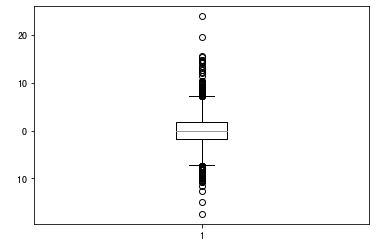

In [21]:
plt.boxplot(x=residuals)

In [24]:
# with variability
bootstrap_predictions = np.zeros((n_bootstrap, len(y)))
bootstrap_prediction_errors = np.zeros((n_bootstrap, len(y)))
for i in range(n_bootstrap):
    X_bootstrap, y_bootstrap = resample(X_spatial_train_, y_train_, n_samples=len(X_spatial_train_), random_state=i)
    model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)
    model.fit(X_bootstrap, y_bootstrap)
    results = model.predict(X_spatial)
    # errors = np.abs(results - y)
#     bootstrap_predictions[i] = results
    # bootstrap_prediction_errors[i] = errors
    resampled_residuals = resample(residuals, n_samples=len(X_spatial))
    preds_with_variability = results + resampled_residuals
    bootstrap_predictions[i] = preds_with_variability

In [25]:
bs_lower_bound = np.percentile(bootstrap_predictions, 5, axis=0)[y_test.index]

In [26]:
bs_upper_bound = np.percentile(bootstrap_predictions, 95, axis=0)[y_test.index]

In [27]:
np.mean((y_test >= bs_lower_bound) & (y_test <= bs_upper_bound))

0.6533333333333333

In [24]:
n_bootstrap_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 400, 500, 750, 1000, 1250, 1500, 1750, 2000]

In [14]:
# n_bootstrap_list = [2000]

In [15]:
coverage_list = []

In [18]:
interval_size_list = []

In [16]:
import time

In [19]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)
model.fit(X_spatial_train_, y_train_)
y_pred_train = model.predict(X_spatial_train_)
residuals = y_train_ - y_pred_train

for n_bootstrap in n_bootstrap_list:
    print(f'resamples: {n_bootstrap}')
    start = time.time()
    bootstrap_predictions = np.zeros((n_bootstrap, len(y)))
    bootstrap_prediction_errors = np.zeros((n_bootstrap, len(y)))
    for i in range(n_bootstrap):
        X_bootstrap, y_bootstrap = resample(X_spatial_train_, y_train_, n_samples=len(X_spatial_train_), random_state=i)
        model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)
        model.fit(X_bootstrap, y_bootstrap)
        results = model.predict(X_spatial)
        errors = np.abs(results - y)
#         bootstrap_predictions[i] = results
#         bootstrap_prediction_errors[i] = errors
        resampled_residuals = resample(residuals, n_samples=len(X_spatial))
        preds_with_variability = results + resampled_residuals
        bootstrap_predictions[i] = preds_with_variability
    bs_lower_bound = np.percentile(bootstrap_predictions, 5, axis=0)[y_test.index]
    bs_upper_bound = np.percentile(bootstrap_predictions, 95, axis=0)[y_test.index]
    interval_size_list.append(np.mean(bs_upper_bound - bs_lower_bound))
    coverage = np.mean((y_test >= bs_lower_bound) & (y_test <= bs_upper_bound))
    end = time.time()
    coverage_list.append(coverage)

resamples: 10
resamples: 20
resamples: 30
resamples: 40
resamples: 50
resamples: 60
resamples: 70
resamples: 80
resamples: 90
resamples: 100
resamples: 110
resamples: 120
resamples: 130
resamples: 140
resamples: 150
resamples: 160
resamples: 170
resamples: 180
resamples: 190
resamples: 200
resamples: 300
resamples: 400
resamples: 500
resamples: 750
resamples: 1000
resamples: 1250
resamples: 1500
resamples: 1750
resamples: 2000


In [20]:
end - start

988.5079817771912

In [30]:
coverage_list = coverage_list[-29:]

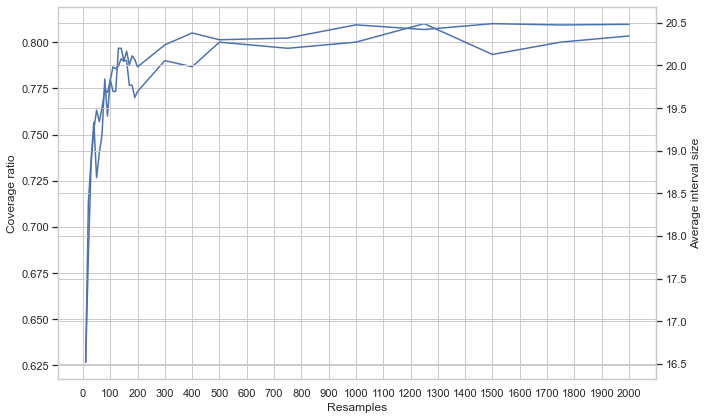

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp')
ax1.set_xticks(np.arange(0, 2001, 100))
ax1.set_xlabel('Resamples')
ax1.set_ylabel('Coverage ratio')
ax1.plot(n_bootstrap_list, coverage_list)

ax2 = ax1.twinx()

ax2.set_ylabel('Average interval size')
ax2.plot(n_bootstrap_list, interval_size_list)

plt.tight_layout()

plt.savefig('./pdf/resamples_coverage_rate_avg_interval_size.pdf', dpi=300, bbox_inches='tight')

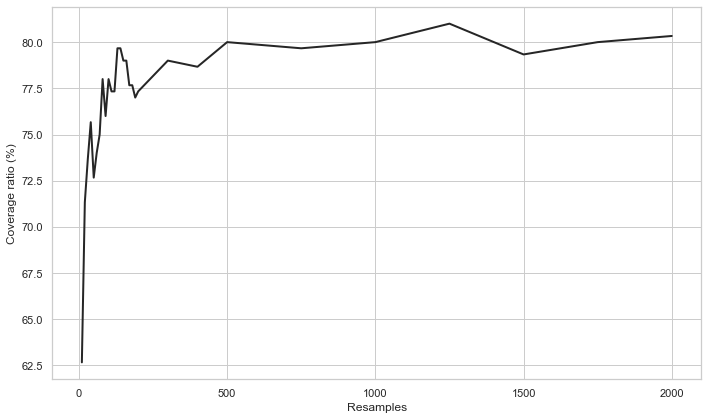

In [31]:
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'SF Pro Display'

plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
sns.lineplot(x=n_bootstrap_list, y=coverage_ratios, lw=2, color='#262626')

plt.ylabel('Coverage ratio (%)')
plt.xlabel('Resamples')
plt.xticks(np.arange(0, 2001, 500))
# plt.legend(loc='upper right')
# plt.axhline(y=0.9366666666666666, color='r', linestyle='-.')
plt.tight_layout()

plt.savefig('./pdf/resamples_coverage_rate_new.pdf', dpi=300, bbox_inches='tight')


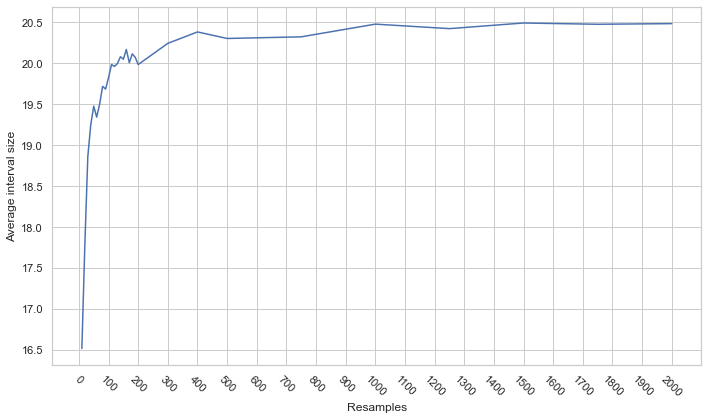

In [35]:
plt.figure(figsize=(10, 6))

sns.set_theme(style="whitegrid")
sns.lineplot(x=n_bootstrap_list, y=interval_size_list)

plt.ylabel('Average interval size')
plt.xlabel('Resamples')
plt.xticks(np.arange(0, 2001, 100), rotation=-45)
# plt.legend(loc='upper right')
# plt.axhline(y=0.9366666666666666, color='r', linestyle='-.')
plt.tight_layout()

plt.savefig('./pdf/resamples_interval_size.pdf', dpi=300, bbox_inches='tight')

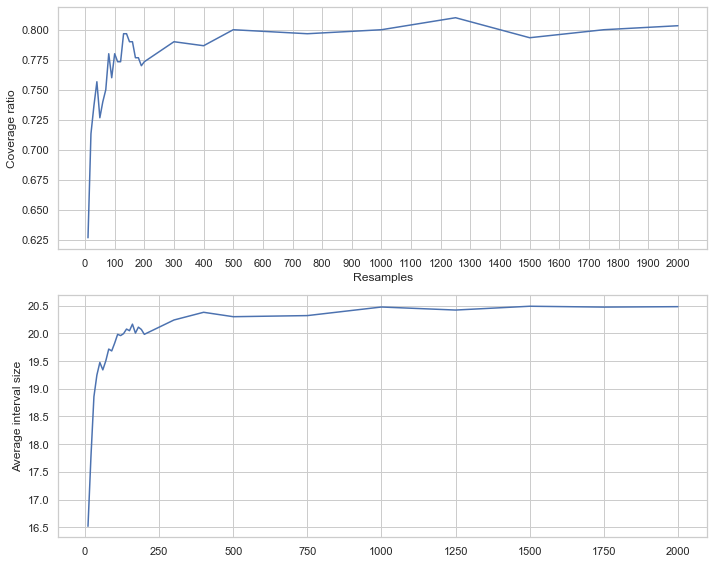

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

ax1, ax2 = axes[0], axes[1]

ax1.set_xticks(np.arange(0, 2001, 100))
ax1.set_xlabel('Resamples')
ax1.set_ylabel('Coverage ratio')
ax1.plot(n_bootstrap_list, coverage_list)

ax1.set_xticks(np.arange(0, 2001, 100))
ax1.set_xlabel('Resamples')
ax2.set_ylabel('Average interval size')
ax2.plot(n_bootstrap_list, interval_size_list)

plt.tight_layout()
plt.savefig('./pdf/resamples_coverage_rate_avg_interval_size.pdf', dpi=300, bbox_inches='tight')

In [39]:
coverage_list

[0.6266666666666667,
 0.7133333333333334,
 0.7366666666666667,
 0.7566666666666667,
 0.7266666666666667,
 0.74,
 0.75,
 0.78,
 0.76,
 0.78,
 0.7733333333333333,
 0.7733333333333333,
 0.7966666666666666,
 0.7966666666666666,
 0.79,
 0.79,
 0.7766666666666666,
 0.7766666666666666,
 0.77,
 0.7733333333333333,
 0.79,
 0.7866666666666666,
 0.8,
 0.7966666666666666,
 0.8,
 0.81,
 0.7933333333333333,
 0.8,
 0.8033333333333333]

In [40]:
interval_size_list

[16.51736829065297,
 17.77615891015142,
 18.85711085058517,
 19.247260190351614,
 19.475176601650993,
 19.341085774361662,
 19.50196013400802,
 19.716559915424593,
 19.682836252763362,
 19.82390360430526,
 19.982507738586932,
 19.95984564518737,
 19.995147442681883,
 20.077760227441395,
 20.04786539296797,
 20.16621996180851,
 20.004662091576375,
 20.112280109169756,
 20.070603104481496,
 19.982650059936766,
 20.24125205810623,
 20.38043897105508,
 20.300789207779427,
 20.320761693635806,
 20.475696552255503,
 20.4208709912061,
 20.489579929711145,
 20.47419592839431,
 20.481986386381777]

In [2]:
coverage_list = [0.6266666666666667,
 0.7133333333333334,
 0.7366666666666667,
 0.7566666666666667,
 0.7266666666666667,
 0.74,
 0.75,
 0.78,
 0.76,
 0.78,
 0.7733333333333333,
 0.7733333333333333,
 0.7966666666666666,
 0.7966666666666666,
 0.79,
 0.79,
 0.7766666666666666,
 0.7766666666666666,
 0.77,
 0.7733333333333333,
 0.79,
 0.7866666666666666,
 0.8,
 0.7966666666666666,
 0.8,
 0.81,
 0.7933333333333333,
 0.8,
 0.8033333333333333]

In [5]:
coverage_ratios = list(map(lambda x: x * 100, coverage_list))

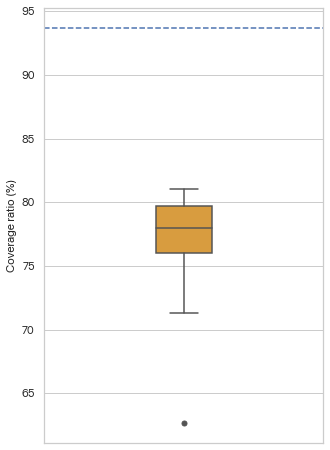

In [30]:
plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'SF Pro Display'

fig, ax = plt.subplots(figsize=(5, 8))

sns.boxplot(y=coverage_ratios, width=0.2, color='#f1a226', flierprops={"marker": "o"},)
ax.set_ylabel('Coverage ratio (%)')

ax.axhline(y=93.7, linestyle='--')

plt.savefig('./pdf/coverage_ratio_comparison.pdf', dpi=300, bbox_inches='tight')